In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_weekly
from sklearn.metrics import mean_absolute_error

In [44]:
df = pd.read_pickle('../../data/time_ecom/dfcatparent.pkl', compression='zip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23838 entries, 1465072 to 1454084
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      23838 non-null  datetime64[ns]
 1   visitorid      23838 non-null  int64         
 2   event          23838 non-null  object        
 3   itemid         23838 non-null  int64         
 4   transactionid  23838 non-null  float64       
 5   category       23838 non-null  int32         
 6   parent         23838 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(1)
memory usage: 1.3+ MB


In [55]:
# for converting to daily frequency
def parent2day(df, select_int, par=True, fb=False):
    """takes DF 23838 with category and parent columns
    outputs daily purchases DF
    select_int is the desired category or parent to be selected
    par=True filters the parent column  //  par=False filters the category column
    fb option toggles 'ds' & 'y' output format for FBprophet
    """
    copy = df.copy()
    # rename for working with FB prophet
    copy.rename(columns={'event':'y'}, inplace=True)
    copy.rename(columns={'timestamp':'ds'}, inplace=True)
    # filter parent
    if par:
        copy = copy[copy['parent'] == select_int].sort_values('ds')
    # filter category
    else:
        copy = copy[copy['category'] == select_int].sort_values('ds')
    # select columns for easier AGG
    copy = copy[['ds', 'y', 'category', 'parent']]
    # resample to daily frequency and count transactions
    dfday = copy.resample('D', on="ds").count() 
    # make and join 139 df to pad missing head and tail
    dr = pd.date_range(start='2015-05-02', end='2015-09-17', freq='D')
    dfmake = pd.DataFrame(index=dr)
    dfmake = dfmake.join(dfday)
    # reset category/parent to be correct
    if par:
        dfmake['parent'] = select_int
    else:
        dfmake['category'] = select_int
    dfmake = dfmake.fillna(0)
    dfmake = dfmake.astype('int32')  #  the join made values floats
    # make ds, y format for FB
    if fb:  
        dfmake = dfmake[['y']].reset_index().rename(columns={'index': 'ds'})
    # remove partial days ( from 139 rows to 137 )
    dfmake = dfmake.iloc[1:-1]
    return dfmake.copy()

In [80]:
def train_prophet(df):
    m = Prophet(changepoint_prior_scale=0.05)
    return m.fit(df)

def predict_horizon(m, horizon=28):
    # dffuture has 'ds' column only
    dffuture = m.make_future_dataframe(periods=horizon)
    dfforecast = m.predict(dffuture)
    """ fb forecast columns
        ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat']"""
    y_hat = dfforecast.iloc[-horizon: , -1].values
    return y_hat

def mape(y_true, y_pred):
    # mean absolute percent error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.

In [57]:
def daily_df_dict(df, id_array):
    df_dict = {}
    for parent in id_array:
        df_dict[parent] = parent2day(df, parent, par=True, fb=True)
    return df_dict

def shf_error(train_dict, shf_period=-28):
    error_dict = {}
    for parent, df in train_dict.items():
        y_true = df.iloc[shf_period, -1]
        m = train_prophet(df[shf_period:])
        dftime = df[['ds']]
        forecast = m.predict(dftime)
        y_hat = forecast.iloc[shf_period, -1]
        error_dict[parent] = mape(y_true, y_hat)
    return error_dict

In [34]:
topparent = np.array([561, 955, 105, 500, 1095, 805])
df['parent'].nunique()  # 236 
parent_counts = df['parent'].value_counts()

In [63]:
ar30parents = parent_counts[parent_counts >= 250].index.values
#size is 30 parents >= 250
ar30parents

array([ 561,  955,  105,  500, 1095,  805, 1426,   -2, 1308, 1606,  121,
        250,  594,  745,  871, 1368,  620, 1667, 1458,  580,  312, 1329,
         20, 1383,  679,  293,  897, 1249,  113,  402])

In [77]:
train_dict = daily_df_dict(df[:-28], topparent)

In [51]:
print(len(train_dict))
train_dict[500][-28:].shape

6


(28, 2)

In [ ]:
first_errors = shf_error(train_dict, shf_period=-28)
for parent, error in first_errors.items():
    print(parent, "parent  :  mape error", round(error, 1))
# 561 parent  :  mape error 711.4302802002786
# 955 parent  :  mape error 70.49148698276977
# 105 parent  :  mape error 17.923334238004994
# 500 parent  :  mape error 19.175125123610925
# 1095 parent  :  mape error 165.30957096914483
# 805 parent  :  mape error 51.27614835005032

In [ ]:
# master insight function (daily_df, horizon=28)
# { parent : object(parent, horizon, df_daily, model, shf_model, df_forecast,
#                           shf_error, percent_growth, hi, low ) }

In [163]:
class PurchaseForecast(object):
    """My description"""
    def __init__(self, parent, horizon, df_daily):
        self.parent = parent
        self.horizon = horizon
        self.df_daily = df_daily
    # list of target values to hold in object
    #   parent, horizon, df_daily, model, shf_model, forecast,
    #   mape_error, abs_error, percent_growth, low, hi
    #   y_true, y_hat  ( from shf error calc )
    def fit(self):
        # runs all the class functions to store values in object
        self._prophet_fit(prior=0.05)
        self._prophet_predict()
        self._shf()
        self._shf_mape()
        self._growth()
    
    def mape(self, y_true, y_pred):
        # mean absolute percent error
        return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100., 1)

    def _prophet_fit(self, prior=0.05):
        self.model = Prophet(changepoint_prior_scale=prior)
        self.shf_model = Prophet(changepoint_prior_scale=prior)
        print(f"start fit shf model parent={self.parent}")
        self.shf_model.fit(self.df_daily[:-self.horizon])
        print(f"start fit full model parent={self.parent}")
        self.model.fit(self.df_daily)
        print(f"finished fitting parent={self.parent}")
        
    def _prophet_predict(self):
        self.future = self.model.make_future_dataframe(periods=self.horizon)
        self.forecast = self.model.predict(self.future)
        
    def _shf_mape(self):
        self.y_true = self.df_daily.iloc[-self.horizon:, -1].values
        self.shf_forecast = self.shf_model.predict(self.future[:-self.horizon])
        self.y_hat = self.shf_forecast.iloc[-self.horizon:, -1].values
        self.mape_error = self.mape(self.y_true, self.y_hat)
        
    def _shf(self):
        self.y_true = self.df_daily.iloc[-self.horizon:, -1].values
        self.shf_forecast = self.shf_model.predict(self.future[:-self.horizon])
        self.y_hat = self.shf_forecast.iloc[-self.horizon:, -1].values
        self.abs_error = mean_absolute_error(self.y_true, self.y_hat)
        
    def _growth(self):
        # 'trend' is the column to use in forecast
        #  also 'trend_lower', 'trend_upper'
        start = self.forecast['trend'].values[-1 - self.horizon]
        mid = self.forecast['trend'].values[-1]
        low = self.forecast['trend_lower'].values[-1]
        high = self.forecast['trend_upper'].values[-1]
        self.percent_growth = ((mid - start) / start) * 100.
        self.low = ((low - start) / start) * 100.
        self.high = ((high - start) / start) * 100.

In [ ]:
# these didn't work inside the class
    def plot_shf(self):
        matplotlib.style.use('seaborn-whitegrid')
        matplotlib.rc('xtick', labelsize=15) 
        matplotlib.rc('ytick', labelsize=15)
        matplotlib.rc('font', size=15)
        fig_shf = self.shf_model.plot(self.shf_forecast[-self.horizon*2:], 
                            xlabel=None, ylabel='Daily Purchases') #, figsize=(10, 6)
        fig_shf.savefig('../img/shf_plot.png')
        return fig_shf
        
    def plot_c(self):
        fig_comp = self.model.plot_components(self.forecast)
        return fig_comp

In [144]:
daily6 = daily_df_dict(df, topparent)
daily30 = daily_df_dict(df, ar30parents)

In [145]:
def models_dict(dict_of_df, horiz=28):
    return_dict = {}
    for key, data in dict_of_df.items():
        forecast_object = PurchaseForecast(key, horiz, data)
        forecast_object.fit()
        return_dict[key] = forecast_object
    return return_dict

In [ ]:
models30 = models_dict(daily30, 28)

In [ ]:
models6 = models_dict(daily6, 28)

In [147]:
# models30
for parent, obj in models6.items():
    print(obj.parent, "parent  :  mape error", obj.shf_error)

561 parent  :  mape error 89.2
955 parent  :  mape error inf
105 parent  :  mape error inf
500 parent  :  mape error inf
1095 parent  :  mape error inf
805 parent  :  mape error inf


In [ ]:
train_dict = daily_df_dict(df[:-28], ar30parents)
first_errors = shf_error(train_dict, shf_period=-28)
for parent, error in first_errors.items():
    print(parent, "parent  :  mape error", round(error, 1))

In [162]:
for parent, obj in models30.items():
    print(obj.parent, "parent  :  percent_growth", round(obj.percent_growth, 1))

561 parent  :  percent_growth 7.7
955 parent  :  percent_growth 0.1
105 parent  :  percent_growth -13.9
500 parent  :  percent_growth -41.2
1095 parent  :  percent_growth 2.1
805 parent  :  percent_growth -8.9
1426 parent  :  percent_growth 14.7
-2 parent  :  percent_growth 8.2
1308 parent  :  percent_growth 3.1
1606 parent  :  percent_growth -63.3
121 parent  :  percent_growth 12.5
250 parent  :  percent_growth -27.0
594 parent  :  percent_growth -8.6
745 parent  :  percent_growth 1.4
871 parent  :  percent_growth 3.5
1368 parent  :  percent_growth 9.2
620 parent  :  percent_growth -0.4
1667 parent  :  percent_growth 8.3
1458 parent  :  percent_growth 6.0
580 parent  :  percent_growth -6.4
312 parent  :  percent_growth 0.5
1329 parent  :  percent_growth 2.5
20 parent  :  percent_growth 0.9
1383 parent  :  percent_growth 7.7
679 parent  :  percent_growth -21.1
293 parent  :  percent_growth 1.1
897 parent  :  percent_growth 11.1
1249 parent  :  percent_growth 11.8
113 parent  :  percent

In [158]:
    # list of target values to hold in object
    #   parent, horizon, df_daily, model, shf_model, forecast,
    #   shf_error, percent_growth, low, hi
    #   y_true, y_hat  ( from shf error calc )
tt1 = models30[1426].df_daily.iloc[-28:, -1]
tt2 = models30[1426].shf_forecast.iloc[-28:, -1]
# np.abs((tt2 - tt1) / tt1)
# print(np.round(np.abs(tt2 - tt1), 0))
# mape(tt1, tt2)
# print(tt1)
# print(models30[1426].df_daily.shape, models30[1426].shf_forecast.shape)
mean_absolute_error(tt1, tt2)

3.142167922996049

In [149]:
models6[105].plot_shf

<bound method PurchaseForecast.plot_shf of <__main__.PurchaseForecast object at 0x7f6930a9c0d0>>

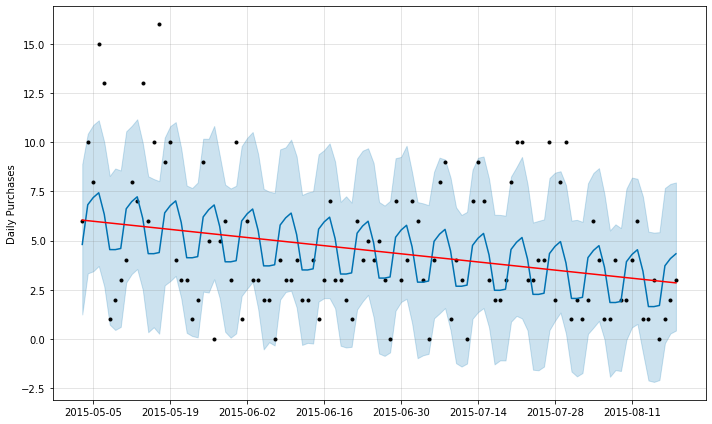

In [161]:
to_show = 500
fig1 = models6[to_show].shf_model.plot(models6[to_show].shf_forecast[:-28], 
                            xlabel=None, ylabel='Daily Purchases')
a = add_changepoints_to_plot(fig1.gca(), models6[to_show].shf_model, 
                             models6[to_show].shf_forecast[:-28])
# fig1.savefig('../img/shf_plot.png')

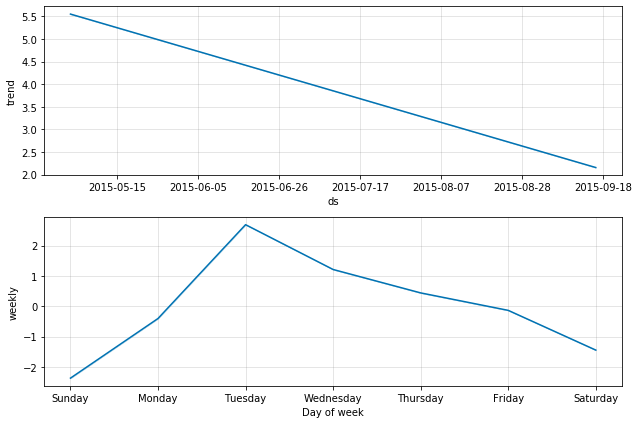

In [159]:
fig2 = models6[105].shf_model.plot_components(models6[105].shf_forecast)
fig2.savefig('../img/shf_components.png')

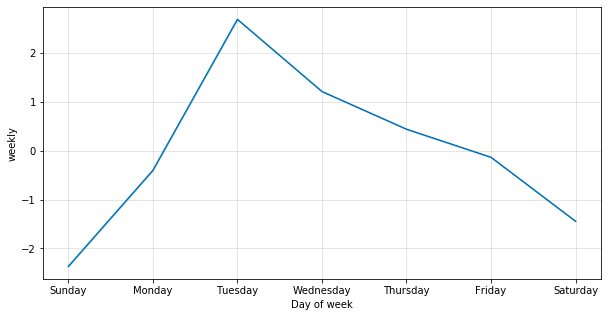

In [160]:
plot_weekly(models6[105].shf_model, figsize=(10,5))